<a href="https://colab.research.google.com/github/shani1610/underwater-object-detection/blob/main/underwater_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster-RCNN with underwater dataset

In [1]:
!git clone https://github.com/shani1610/underwater-object-detection.git

Cloning into 'underwater-object-detection'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 68 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 18.89 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
%cd underwater-object-detection

/content/underwater-object-detection


In [3]:
!pip install -r requirements.txt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 823.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 50.2 MB/s eta 0:00:00


In [4]:
import os
current_path = os.getcwd()
print(current_path)

/content/underwater-object-detection


In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image
import json

In [6]:
from torchinfo import summary

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# Since we're creating a new layer with random weights
# let's set the seeds
set_seeds()

# Download the data

you can download directly from kaggle and put the files inside of a directory named data.
or you can use the following code.
the code download the zip file and then extract it, move the aquarium_pretrain contet directly to data folder and remove it and the zip.
at the end you need to have:

-- data

---- test

---- train

---- valid

---- README.dataset.txt

---- README.roboflow.txt

---- data.yaml


In [9]:
import shutil

# Define dataset path
dataset_path = os.path.join(current_path, "data")

# Check if the folder exists and is not empty
if not os.path.exists(dataset_path) or not any(os.listdir(dataset_path)):
    print("Dataset missing or empty. Downloading...")
    # Add your data download command here, for example:
    os.environ['KAGGLE_USERNAME'] = 'sisraelo'
    os.environ['KAGGLE_KEY'] = 'b828caf539942769d8cdb923fa1f2e74'
    # Verify Kaggle setup
    !kaggle datasets list
    os.makedirs(dataset_path, exist_ok=True)  # Ensure the "data" directory exists
    # Download dataset to "data" folder
    !kaggle datasets download slavkoprytula/aquarium-data-cots -p data
    # Unzip dataset into the "data" directory
    zip_path = os.path.join(dataset_path, "aquarium-data-cots.zip")
    !unzip -q {zip_path} -d {dataset_path}
    # Find and move all contents from the extracted folder to "data/"
    extracted_folder = os.path.join(dataset_path, "aquarium_pretrain")
    if os.path.exists(extracted_folder):
        for item in os.listdir(extracted_folder):
            shutil.move(os.path.join(extracted_folder, item), dataset_path)  # Move everything
        # Remove the now-empty aquarium_pretrain folder
        shutil.rmtree(extracted_folder)
    # Remove the zip file after extraction
    os.remove(zip_path)
    print("Download and extraction complete.")
else:
    print("Dataset already exists. Skipping download.")

Dataset missing or empty. Downloading...
ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
anandshaw2001/netflix-movies-and-tv-shows                     Netflix Movies and TV Shows                         1MB  2025-01-03 10:33:01          14973        393  1.0              
asinow/car-price-dataset                                      Car Price Dataset                                 135KB  2025-01-26 19:53:28           4484         60  1.0              
arshmankhalid/shopify-streaming-history-dataset               Spotify Streaming History Dataset                   6MB  2025-01-29 05:30:39            906         34  0.9411765        
wlwwwlw/elite-sports-cars-in-data      

In [10]:
os.makedirs(os.path.join(current_path, "scripts"), exist_ok=True)


In [11]:
!touch scripts/__init__.py


In [56]:
%%writefile scripts/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os
import yaml
import torch
import shutil
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import to_tensor  # Import ToTensor for manual conversion
import numpy as np
from torch.utils.data import WeightedRandomSampler
from collections import Counter

#UNDERREPRESENTED_CLASSES = set()
#AUGMENTATION_PROBABILITY = 0.5  # ✅ Only apply augmentation 50% of the time

# Apply horizontal flip to ALL images
def get_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5)  # ✅ Flip all images
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

### 1. Load Class Names and Ensure Correct Indexing ###
def get_class_names(yaml_path):
    """Loads class names from YOLO data.yaml and ensures correct indexing for Faster R-CNN."""
    if not os.path.exists(yaml_path):
        raise FileNotFoundError(f"data.yaml not found at {yaml_path}")

    with open(yaml_path, "r") as f:
        try:
            data = yaml.safe_load(f)
            if "names" not in data:
                raise KeyError("'names' key not found in data.yaml")
        except yaml.YAMLError as e:
            raise ValueError(f"YAML parsing error: {e}")

    class_names = data["names"]
    class_id_mapping = {i + 1: name for i, name in enumerate(class_names)}

    return class_names, class_id_mapping

### 2. Define the Dataset Class ###
class AquariumDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, augmentations=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.augmentations = augmentations
        self.imgs = sorted(os.listdir(images_dir))
        self.labels = sorted(os.listdir(labels_dir))
        #print(f"✅ Loaded {len(self.imgs)} images from {self.images_dir}")
        #print(f"✅ Sample file names: {self.imgs[:5]}")  # Print first 5 image names

    @staticmethod
    def yolo_to_fasterrcnn(box, img_width, img_height):
        """Converts YOLO bbox (x_center, y_center, width, height) to Faster R-CNN format (x_min, y_min, x_max, y_max)."""
        x_center, y_center, width, height = box
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height
        return [x_min, y_min, x_max, y_max]

    def __getitem__(self, idx):
        """Loads an image and its annotations, ensuring correct class IDs."""
        if idx >= len(self.imgs):
          print(f"⚠️ ERROR: Requested index {idx}, but only {len(self.imgs)} images exist!")
          raise IndexError("Dataset index out of range")
        img_path = os.path.join(self.images_dir, self.imgs[idx])
        #print(f"✅ Loading image {img_path}")
        label_path = os.path.join(self.labels_dir, self.labels[idx])

        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        boxes, labels = [], []
        with open(label_path, "r") as f:
            for line in f:
                label_info = line.strip().split()
                original_class_id = int(label_info[0])  # YOLO starts at 0
                class_id = original_class_id + 1  # Shift to 1-based for Faster R-CNN

                # Convert YOLO bbox format
                x_center, y_center, width, height = map(float, label_info[1:])
                boxes.append(self.yolo_to_fasterrcnn([x_center, y_center, width, height], img_width, img_height))
                labels.append(class_id)

        if not boxes:
            return None  # Skip empty annotations

        # Keep Augmentation Step Here But Do Not Apply It Yet
        img_np = np.array(img)

        # Apply augmentations if provided
        if self.augmentations:
            augmented = self.augmentations(image=img_np, bboxes=boxes, category_ids=labels)
            img_np = augmented["image"]
            boxes = augmented["bboxes"]
            labels = augmented["category_ids"]

        # Convert back to PIL for PyTorch Transforms
        img = Image.fromarray(img_np)

        # Apply PyTorch Transforms (ToTensor)
        if self.transforms:
            img = self.transforms(img)
        else:
            img = to_tensor(img)  # Manually convert to Tensor if no transform is provided

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }

        return img, target

    def __len__(self):
        return len(self.imgs)


### 3. Create a Function to Generate Dataloaders ###
def create_dataloader(images_dir, labels_dir, batch_size=2, num_workers=1, augmentations=None):
    """Creates a PyTorch DataLoader for object detection."""
    # Default transformations
    transform = T.ToTensor()  # No more list summation

    dataset = AquariumDataset(images_dir, labels_dir, transforms=transform, augmentations=augmentations)
    #print(f"🔍 Dataset length from __len__(): {len(dataset)}")
    #print(f"🔍 Number of images in dataset.imgs: {len(dataset.imgs)}")
    # Filter out None samples before counting class occurrences
    # Print how many `None` samples exist in the dataset
    # Count occurrences of each class
    # Count class occurrences without loading full dataset into memory
    class_counts = Counter()
    for idx in range(len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            _, target = sample
            for label in target["labels"].tolist():
              class_counts[label] += 1

    # Compute class weights (inverse frequency)
    total_samples = sum(class_counts.values())
    class_weights = {cls_id: total_samples / count for cls_id, count in class_counts.items()}

    # Assign a weight for each image in the dataset
    sample_weights = []
    for idx in range(len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            _, target = sample
            sample_weights.append(class_weights[target["labels"][0].item()])  # Assign weight to first label

    #print(f"🔍 Total dataset size: {len(dataset)}")
    #print(f"🔍 Total samples in sampler: {len(sample_weights)}")
    # Create WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(dataset), replacement=True)

    def custom_collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))  # Remove None entries
        if not batch:  # Prevent empty batch errors
          return None
        return tuple(zip(*batch))

    return DataLoader(dataset, batch_size=batch_size,  sampler=sampler, collate_fn=custom_collate_fn, num_workers=num_workers)

def create_dataloaders(root_dir="data", batch_size=2, num_workers=0, augmentations=None):
    """Creates training, validation, and test DataLoaders dynamically."""
    train_dataloader = create_dataloader(
        images_dir=os.path.join(root_dir, "train", "images"),
        labels_dir=os.path.join(root_dir, "train", "labels"),
        batch_size=batch_size,
        num_workers=num_workers,
        augmentations=augmentations
    )

    val_dataloader = create_dataloader(
        images_dir=os.path.join(root_dir, "valid", "images"),
        labels_dir=os.path.join(root_dir, "valid", "labels"),
        batch_size=batch_size,
        num_workers=num_workers
    )

    test_dataloader = create_dataloader(
        images_dir=os.path.join(root_dir, "test", "images"),
        labels_dir=os.path.join(root_dir, "test", "labels"),
        batch_size=batch_size,
        num_workers=num_workers
    )
    return train_dataloader, val_dataloader, test_dataloader

Overwriting scripts/data_setup.py


In [57]:
import importlib
import scripts.data_setup  # Import the module

importlib.reload(scripts.data_setup)  # Reload the module

<module 'scripts.data_setup' from '/content/underwater-object-detection/scripts/data_setup.py'>

In [58]:
from scripts.data_setup import create_dataloaders, get_class_names, get_augmentations

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    root_dir=dataset_path,
    batch_size=4,
    num_workers=0,
    augmentations=get_augmentations(),
)



In [59]:
dataset = train_loader.dataset  # Get dataset from DataLoader

print(f"🔍 Dataset length from __len__(): {len(dataset)}")
print(f"🔍 Number of images in self.imgs: {len(dataset.imgs)}")


🔍 Dataset length from __len__(): 448
🔍 Number of images in self.imgs: 448


In [60]:
# Check one batch
for images, targets in train_loader:
    print("Image shape:", images[0].shape)  # Should be (3, H, W)
    print("Target sample:", targets[0])  # Check box & label structure
    break

Image shape: torch.Size([3, 1024, 768])
Target sample: {'boxes': tensor([[ 31.5000, 435.0000,  94.5000, 491.0000],
        [379.5000, 417.0000, 464.5000, 455.0000]]), 'labels': tensor([6, 6])}


In [61]:
yaml_file_path = os.path.join(current_path, "data/data.yaml")
class_names, class_id_mapping = get_class_names(yaml_file_path)
print("Class Names:", class_names)
print("Class ID Mapping:", class_id_mapping)

Class Names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Class ID Mapping: {1: 'fish', 2: 'jellyfish', 3: 'penguin', 4: 'puffin', 5: 'shark', 6: 'starfish', 7: 'stingray'}


In [62]:
from collections import Counter

# Initialize label counter
label_counter = Counter()

# Iterate over the full dataset
for _, targets in train_loader:  # Access train_dataloader
    for target in targets:
        label_counter.update(target["labels"].tolist())

# Print the final label distribution
print("\n🔍 **Baseline Class Label Distribution:**")
for cls_id, count in sorted(label_counter.items()):
    print(f" - Class {cls_id}: {count} instances")

# Ensure all expected classes are present
missing_classes = set(range(1, 8)) - set(label_counter.keys())
if missing_classes:
    print(f"\n⚠️ WARNING: The following classes are missing in the dataset: {missing_classes}")
else:
    print("\n✅ All expected classes are present in the dataset.")


# Ensure underrepresented classes are appearing more
underrepresented_classes = {4, 5, 6, 7}
for cls in underrepresented_classes:
    print(f"Class {cls} should now appear more frequently: {label_counter[cls]} occurrences")


🔍 **Baseline Class Label Distribution:**
 - Class 1: 1031 instances
 - Class 2: 200 instances
 - Class 3: 203 instances
 - Class 4: 302 instances
 - Class 5: 211 instances
 - Class 6: 220 instances
 - Class 7: 189 instances

✅ All expected classes are present in the dataset.
Class 4 should now appear more frequently: 302 occurrences
Class 5 should now appear more frequently: 211 occurrences
Class 6 should now appear more frequently: 220 occurrences
Class 7 should now appear more frequently: 189 occurrences



# Inspect The Data

very important to make sure there's no offset, is the first class correspond to 0 or 1?

In [63]:
for images, targets in train_loader:
    # Extract the labels tensor
    labels = targets[0]["labels"]

    # Subtract 1 to match the class_names indexing
    class_names_in_batch = [class_names[label.item() - 1] for label in labels]

    print("Labels in the first batch:", labels.tolist())  # Convert to list for readability
    print("Class names in the first batch:", class_names_in_batch)
    break

Labels in the first batch: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Class names in the first batch: ['penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin']


Batch Inspection:
Image shapes: [torch.Size([3, 1024, 768]), torch.Size([3, 1024, 768]), torch.Size([3, 1024, 768]), torch.Size([3, 1024, 768])]
Target 0:
Boxes shape: torch.Size([3, 4])
Labels shape: torch.Size([3])
Boxes: tensor([[296.0000, 502.5000, 478.0000, 623.5000],
        [  1.0000, 307.5000, 153.0000, 416.5000],
        [547.5000, 447.5000, 638.5000, 520.5000]])
Labels: tensor([6, 1, 1])


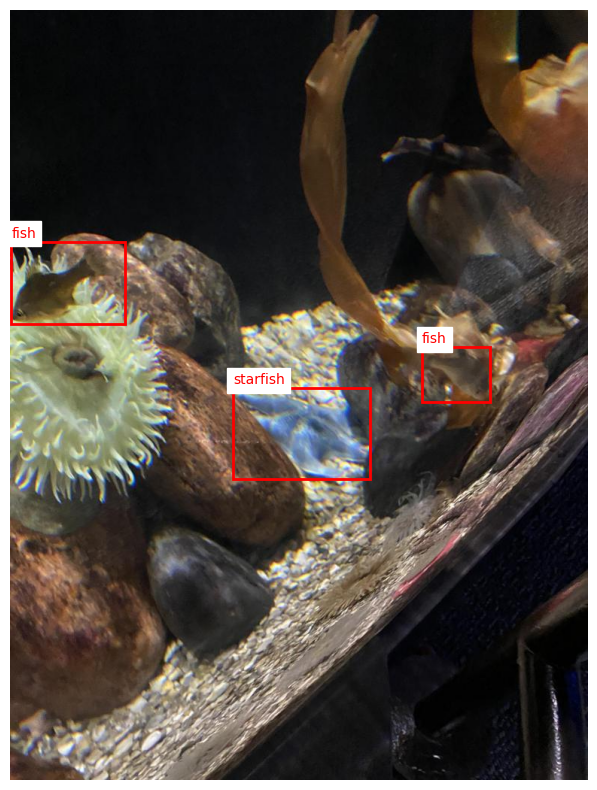

Target 1:
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Boxes: tensor([[169.5000, 182.5000, 696.5000, 613.5000]])
Labels: tensor([7])


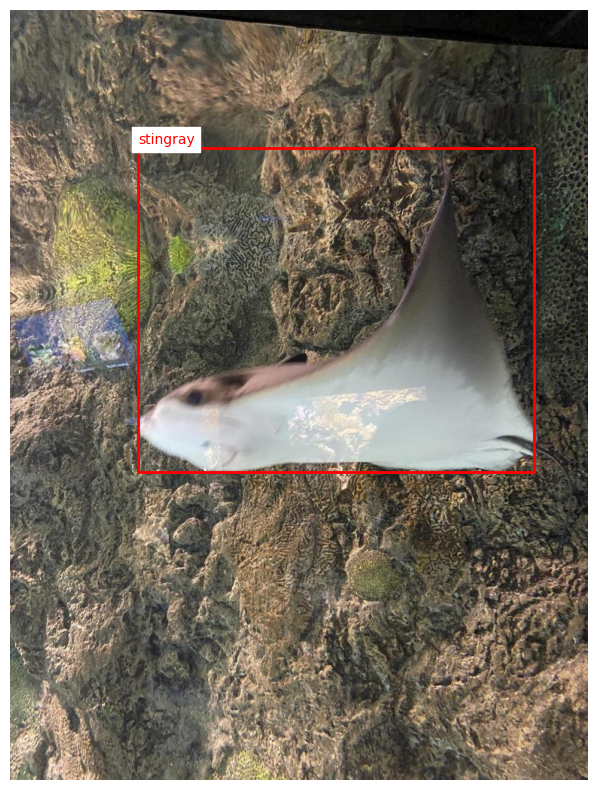

Target 2:
Boxes shape: torch.Size([7, 4])
Labels shape: torch.Size([7])
Boxes: tensor([[350.0000, 490.5000, 418.0000, 607.5000],
        [495.5000, 266.0000, 566.5000, 372.0000],
        [158.0000, 554.5000, 274.0000, 645.5000],
        [490.5000, 470.5000, 573.5000, 541.5000],
        [708.0000, 415.5000, 768.0000, 484.5000],
        [609.5000, 475.0000, 682.5000, 541.0000],
        [358.5000, 258.5000, 429.5000, 311.5000]])
Labels: tensor([4, 4, 4, 4, 4, 4, 4])


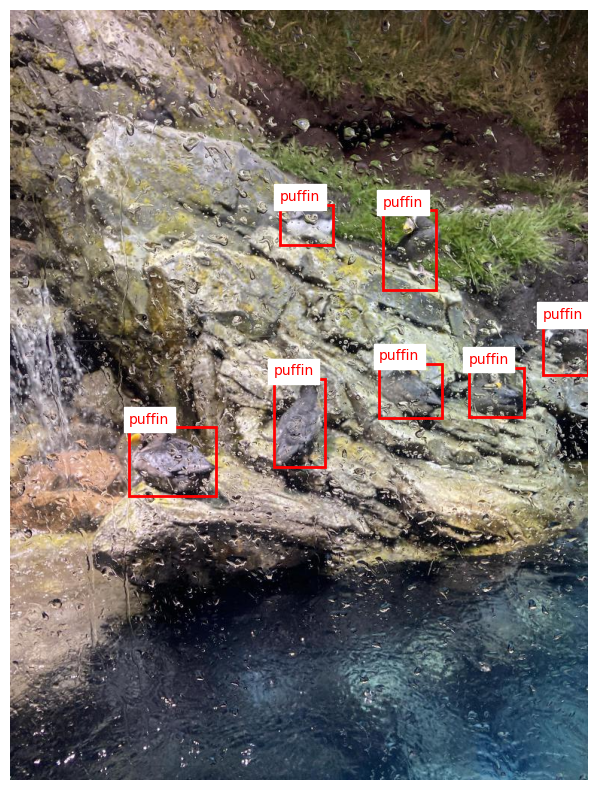

Target 3:
Boxes shape: torch.Size([5, 4])
Labels shape: torch.Size([5])
Boxes: tensor([[ 20.5000, 179.5000, 725.5000, 746.5000],
        [ 97.5000, 437.0000, 270.5000, 661.0000],
        [335.0000, 353.5000, 703.0000, 576.5000],
        [613.0000, 740.5000, 767.0000, 821.5000],
        [271.0000, 725.0000, 447.0000, 787.0000]])
Labels: tensor([6, 6, 6, 6, 6])


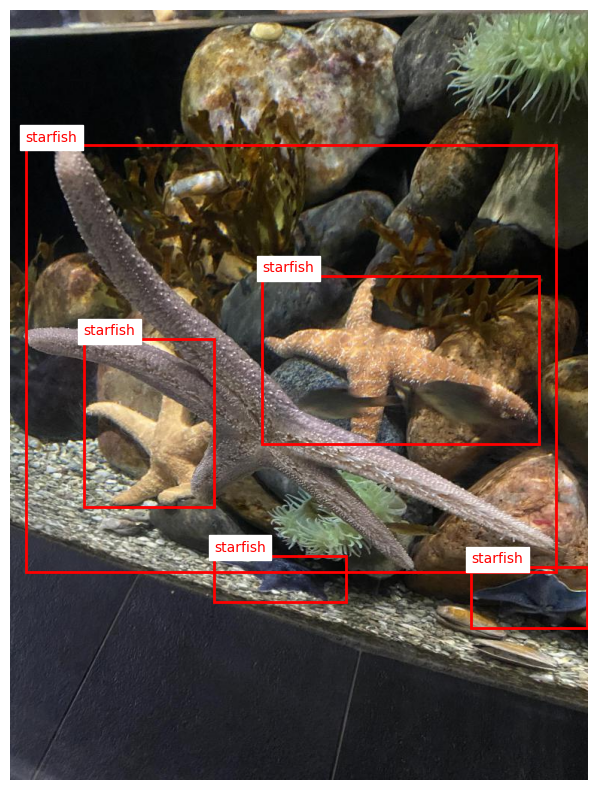

In [64]:
from matplotlib import patches
import matplotlib.pyplot as plt

# Inspect a batch
for images, targets in train_loader:
    print("Batch Inspection:")
    print("Image shapes:", [img.shape for img in images])  # List of shapes for each image in the batch

    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print("Boxes shape:", target["boxes"].shape)  # Expect shape [N, 4], where N is the number of boxes
        print("Labels shape:", target["labels"].shape)  # Expect shape [N], where N is the number of labels
        print("Boxes:", target["boxes"])  # Optional: to see the actual coordinates
        print("Labels:", target["labels"])  # Optional: to see the actual labels

        # Visualize the first two images with bounding boxes and labels
        if i < 4:  # Visualize up to 2 images
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC for plotting
            ax.imshow(img)

            # Plot bounding boxes
            for box, label in zip(target["boxes"], target["labels"]):
                x_min, y_min, x_max, y_max = box.cpu().numpy()
                width = x_max - x_min
                height = y_max - y_min

                # Map label to class name directly (adjusting for one-based labels)
                class_name = class_names[label.item() - 1]

                # Add bounding box and label
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, class_name, color='red', fontsize=10, backgroundcolor="white")

            ax.axis("off")
            plt.show()

    break  # Exit after inspecting the first batch

# Exploratory Data Analysis (EDA)

If some classes appear in fewer images but with a large number of objects (e.g., jellyfish), it indicates group behavior.
If other classes appear in many images but only once per image (e.g., starfish), it indicates solitary behavior.
Insights You Can Derive
Class-Level Trends

Are some classes consistently smaller in bounding box size?
Do other classes occupy a significant portion of the image?

Potential Issues:

Small objects may be harder for the model to detect.
Classes with consistently large boxes may dominate training.

more
Class Co-Occurrence
Analyze which classes often appear together in the same image.
Helps in understanding dataset diversity and dependency between classes.

In [21]:
%%writefile scripts/eda.py
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
from itertools import combinations

class EDA:
    """Exploratory Data Analysis (EDA) for Object Detection datasets."""

    def __init__(self, save_dir="EDA"):
        """Initialize EDA class with a directory to save visualizations."""
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def count_class_occurrences(self, dataloader, class_names):
        """Counts occurrences of each class in the dataset."""
        class_counts = Counter()
        objects_per_image = defaultdict(list, {cls: [] for cls in class_names})
        for idx, (_, targets) in enumerate(dataloader):
            for target in targets:
                if "labels" not in target or len(target["labels"]) == 0:
                    continue
                labels = target["labels"].tolist()
                class_counts.update(labels)
                for label in labels:
                    objects_per_image[class_names[label - 1]].append(idx)
        image_counts = {cls: len(set(image_list)) for cls, image_list in objects_per_image.items()}
        object_counts = {cls: len(image_list) for cls, image_list in objects_per_image.items()}
        return class_counts, object_counts, image_counts

    def plot_bar_chart(self, data_dict, title, xlabel, ylabel, save_path, color="skyblue", format_values=False):
        """Helper function to plot a bar chart with counts."""
        classes = list(data_dict.keys())
        counts = list(data_dict.values())
        plt.figure(figsize=(10, 6))
        bars = plt.bar(classes, counts, color=color)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        for bar, count in zip(bars, counts):
            value = f"{count:.2f}" if format_values else str(count)
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), value, ha='center', va='bottom', fontsize=10, fontweight='bold')
        plt.savefig(save_path)
        plt.close()

    def plot_class_distribution(self, dataloader, class_names, save_path):
        """Plots and saves the class distribution in the dataset."""
        class_counts, _, _ = self.count_class_occurrences(dataloader, class_names)
        class_distribution = {class_names[cls - 1]: count for cls, count in class_counts.items()}
        self.plot_bar_chart(class_distribution, "Class Distribution in Dataset", "Classes", "Number of Samples", save_path, color="skyblue")

    def plot_image_distribution(self, dataloader, class_names, image_save_path):
        """Plots and saves the distribution of total objects and images containing each class."""
        _, object_counts, image_counts = self.count_class_occurrences(dataloader, class_names)
        image_counts = dict(sorted(image_counts.items(), key=lambda x: x[1], reverse=True))
        self.plot_bar_chart(image_counts, "Images Containing Each Class", "Classes", "Number of Images", image_save_path, color="lightblue")

    def plot_average_objects_per_image(self, dataloader, class_names, save_path):
        """Plots and saves the average objects per image for each class."""
        _, object_counts, image_counts = self.count_class_occurrences(dataloader, class_names)
        average_objects_per_image = {cls: object_counts.get(cls, 0) / image_counts.get(cls, 1) for cls in class_names}
        self.plot_bar_chart(average_objects_per_image, "Average Objects per Image", "Classes", "Average Objects", save_path, color="skyblue", format_values=True)

    def plot_class_co_occurrence(self, dataloader, class_names, save_path):
        """Plots and saves class co-occurrence counts."""
        co_occurrence = defaultdict(int)
        for _, targets in dataloader:
            for target in targets:
                labels = set(target["labels"].tolist())
                for pair in combinations(labels, 2):
                    co_occurrence[pair] += 1
        co_occurrence_pairs = [f"{class_names[p[0] - 1]} & {class_names[p[1] - 1]}" for p in co_occurrence.keys()]
        co_occurrence_counts = list(co_occurrence.values())
        self.plot_bar_chart(dict(zip(co_occurrence_pairs, co_occurrence_counts)), "Class Co-Occurrence", "Class Pairs", "Frequency", save_path, color="skyblue")

    def plot_aspect_ratio_distribution(self, dataloader, class_names, save_path):
        """Plots and saves aspect ratio distribution per class."""
        aspect_ratios = defaultdict(list)
        for _, targets in dataloader:
            for target in targets:
                for box, label in zip(target["boxes"], target["labels"]):
                    x_min, y_min, x_max, y_max = box.cpu().numpy()
                    width = x_max - x_min
                    height = y_max - y_min
                    aspect_ratios[class_names[label.item() - 1]].append(width / height)
        plt.figure(figsize=(10, 6))
        for label, ratios in aspect_ratios.items():
            plt.hist(ratios, bins=30, alpha=0.5, label=label)
        plt.xlabel("Aspect Ratio (Width / Height)")
        plt.ylabel("Frequency")
        plt.title("Aspect Ratio Distribution per Class")
        plt.legend()
        plt.savefig(save_path)
        plt.close()

    def explore_avg_sizes(self, dataloader):
      # Initialize storage for bounding box stats
      bbox_stats = defaultdict(list)

      # Iterate over the DataLoader
      for images, targets in dataloader:
          for img, target in zip(images, targets):
              img_area = img.shape[1] * img.shape[2]  # Image area (Height x Width)
              for box, label in zip(target["boxes"], target["labels"]):
                  x_min, y_min, x_max, y_max = box.cpu().numpy()
                  width = x_max - x_min
                  height = y_max - y_min
                  bbox_area = width * height
                  proportion = bbox_area / img_area

                  # Adjust for label mapping and store stats per class
                  bbox_stats[class_names[label.item() - 1]].append((width, height, bbox_area, proportion))

      # Calculate averages for each class
      bbox_avg_stats = {
          cls: {
              "avg_width": np.mean([stat[0] for stat in stats]),
              "avg_height": np.mean([stat[1] for stat in stats]),
              "avg_area": np.mean([stat[2] for stat in stats]),
              "avg_proportion": np.mean([stat[3] for stat in stats]),
          }
          for cls, stats in bbox_stats.items()
      }

      # Print results
      print("Average Bounding Box Stats per Class:")
      for cls, stats in bbox_avg_stats.items():
          print(f"{cls}:")
          print(f"  Avg Width: {stats['avg_width']:.2f} px")
          print(f"  Avg Height: {stats['avg_height']:.2f} px")
          print(f"  Avg Area: {stats['avg_area']:.2f} px²")
          print(f"  Avg Proportion: {stats['avg_proportion']:.2%} of the image")

      # Prepare data for visualization
      classes = list(bbox_avg_stats.keys())
      avg_widths = [stats["avg_width"] for stats in bbox_avg_stats.values()]
      avg_heights = [stats["avg_height"] for stats in bbox_avg_stats.values()]
      avg_areas = [stats["avg_area"] for stats in bbox_avg_stats.values()]
      avg_proportions = [stats["avg_proportion"] for stats in bbox_avg_stats.values()]

      # Visualize all metrics in a single plot
      fig, ax = plt.subplots(2, 2, figsize=(15, 10))

      # Average Width
      ax[0, 0].bar(classes, avg_widths, color='skyblue')
      ax[0, 0].set_title("Average Width per Class")
      ax[0, 0].set_ylabel("Width (px)")
      ax[0, 0].tick_params(axis='x', rotation=45)

      # Average Height
      ax[0, 1].bar(classes, avg_heights, color='skyblue')
      ax[0, 1].set_title("Average Height per Class")
      ax[0, 1].set_ylabel("Height (px)")
      ax[0, 1].tick_params(axis='x', rotation=45)

      # Average Area
      ax[1, 0].bar(classes, avg_areas, color='skyblue')
      ax[1, 0].set_title("Average Area per Class")
      ax[1, 0].set_ylabel("Area (px²)")
      ax[1, 0].tick_params(axis='x', rotation=45)

      # Average Proportion
      ax[1, 1].bar(classes, avg_proportions, color='skyblue')
      ax[1, 1].set_title("Average Proportion of Image per Class")
      ax[1, 1].set_ylabel("Proportion")
      ax[1, 1].tick_params(axis='x', rotation=45)

      plt.tight_layout()
      plt.show()

    def run_all_eda(self, dataloader, class_names, save_dir):
        """Runs all EDA functions and saves outputs without visualization."""
        os.makedirs(save_dir, exist_ok=True)
        self.plot_class_distribution(dataloader, class_names, os.path.join(save_dir, "class_distribution.png"))
        self.plot_image_distribution(dataloader, class_names, os.path.join(save_dir, "image_counts.png"))
        self.plot_average_objects_per_image(dataloader, class_names, os.path.join(save_dir, "avg_objects_per_image.png"))
        self.plot_class_co_occurrence(dataloader, class_names, os.path.join(save_dir, "class_co_occurrence.png"))
        self.plot_aspect_ratio_distribution(dataloader, class_names, os.path.join(save_dir, "aspect_ratio_distribution.png"))



Writing scripts/eda.py


In [22]:
import importlib
import scripts.eda  # Import the module

importlib.reload(scripts.eda)  # Reload the module

<module 'scripts.eda' from '/content/underwater-object-detection/scripts/eda.py'>

In [23]:
from scripts.eda import EDA

# Initialize EDA
eda_output_path = os.path.join(current_path, "EDA")

# Running EDA on train, val, and test
eda = EDA(eda_output_path)
eda.run_all_eda(train_loader, class_names, "EDA/train")
#eda.run_all_eda(val_loader, class_names, "EDA/val")
#eda.run_all_eda(test_loader, class_names, "EDA/test")

Check for images without bounding boxes or invalid annotations (e.g., zero-area boxes).

In [24]:
missing_annotations = 0
zero_area_boxes = 0
total_images = 0

# Iterate through the DataLoader
for _, targets in train_loader:  # Ensures every batch is processed
    total_images += len(targets)  # Count total images in the batch
    for target in targets:
        # Check for missing annotations
        if len(target["labels"]) == 0:
            missing_annotations += 1
            continue  # Skip further checks for this target

        # Check for zero-area bounding boxes
        for box in target["boxes"]:
            x_min, y_min, x_max, y_max = box.cpu().numpy()
            if x_max <= x_min or y_max <= y_min:
                zero_area_boxes += 1

# Report results
print(f"Total Images Processed: {total_images}")
print(f"Images with Missing Annotations: {missing_annotations}")
print(f"Bounding Boxes with Zero Area: {zero_area_boxes}")

Total Images Processed: 447
Images with Missing Annotations: 0
Bounding Boxes with Zero Area: 0


In [25]:
# Assuming your DataLoader objects are named train_loader, valid_loader, and test_loader
train_count = len(train_loader.dataset)
valid_count = len(val_loader.dataset)
test_count = len(test_loader.dataset)

# Print the counts
print("Number of Images in Each Set:")
print(f"Train: {train_count}")
print(f"Valid: {valid_count}")
print(f"Test: {test_count}")

Number of Images in Each Set:
Train: 448
Valid: 127
Test: 63


Aspect Ratio Distribution
Analyze the aspect ratios of bounding boxes (width/height).
Classes with highly varied or skewed aspect ratios may require specific augmentation or anchor tuning.

Object Density per Image
Calculate the average number of objects per image and its variance.
Identify if certain images or classes are over- or underpopulated.

# Load Pretrained Model

Load Pretrained Faster R-CNN  and Modify for Fine-tuning

In [65]:
# Define a wrapper for Faster R-CNN to accept a single tensor batch
class FasterRCNNWrapper(torch.nn.Module):
    def __init__(self, model):
        super(FasterRCNNWrapper, self).__init__()
        self.model = model

    def forward(self, images, targets=None):
        """
        Forward method that passes images and targets to the wrapped model.
        """
        if self.training:
            # During training, return the loss dictionary
            return self.model(images, targets)
        else:
            # During inference, return predictions
            return self.model(images)

# Load Faster R-CNN model
fasterrcnn = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the box predictor to adjust the number of classes
num_classes = len(class_names) + 1  # 7 classes + 1 background
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features  # Get the number of input features gives the number of input features to this layer, which matches the output size of the previous layer in the roi_heads.
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # Replace with new predictor

# Wrap the model
model = FasterRCNNWrapper(fasterrcnn).to("cuda")
model.eval()  # Set model to evaluation mode

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers
for param in model.model.roi_heads.box_predictor.parameters():  # Access the underlying model
    param.requires_grad = True

# Create a dummy input batch (batch_size=2)
dummy_images = torch.rand(2, 3, 224, 224).to("cuda")  # Batch of images

# Use torchinfo to print the model summary
summary(
    model=model,
    input_data=dummy_images,  # Pass the batch as a single tensor
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
FasterRCNNWrapper (FasterRCNNWrapper)                        [2, 3, 224, 224]     [100, 4]             --                   Partial
├─FasterRCNN (model)                                         [2, 3, 224, 224]     [100, 4]             --                   Partial
│    └─GeneralizedRCNNTransform (transform)                  [2, 3, 224, 224]     [2, 3, 800, 800]     --                   --
│    └─BackboneWithFPN (backbone)                            [2, 3, 800, 800]     [2, 256, 13, 13]     --                   False
│    │    └─IntermediateLayerGetter (body)                   [2, 3, 800, 800]     [2, 2048, 25, 25]    (23,454,912)         False
│    │    └─FeaturePyramidNetwork (fpn)                      [2, 256, 200, 200]   [2, 256, 13, 13]     (3,344,384)          False
│    └─RegionProposalNetwork (rpn)                           [2, 3, 800, 800]     [10

In [66]:
print("Box Predictor Setup:")
print(f"Number of classes: {fasterrcnn.roi_heads.box_predictor.cls_score.out_features}")
print(f"Input features to box predictor: {fasterrcnn.roi_heads.box_predictor.cls_score.in_features}")

Box Predictor Setup:
Number of classes: 8
Input features to box predictor: 1024


# Engine

the train step, val step

Faster R-CNN behaves differently in train() and eval() modes:
When model.train(), it returns a loss dictionary {loss_classifier, loss_box_reg, ...}.
When model.eval(), it only returns predictions (a list of dictionaries with boxes, labels, scores).Solution: Temporarily Enable model.train() in val_step()

In [67]:
%%writefile scripts/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

def train_step(model, train_loader, optimizer, device):
    model.train()  # Set model to training mode
    epoch_loss = 0
    for images, targets in train_loader:
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return epoch_loss

def val_step(model, val_loader, device):
  # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:  # Assuming val_dataloader is defined
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily enable training mode to compute validation loss
            model.train()
            loss_dict = model(images, targets)
            model.eval()  # Switch back to eval mode

            # Accumulate validation loss
            val_loss += sum(loss for loss in loss_dict.values()).item()
    return val_loss

def train(model, num_epochs, train_loader, val_loader, optimizer, lr_scheduler, device):
    train_losses = []  # To store training loss per epoch
    val_losses = []  # To store validation loss per epoch
    learning_rates = []  # To store learning rates
    # Training Loop
    for epoch in range(num_epochs):
        # Training Step
        epoch_loss = train_step(model, train_loader, optimizer, device)

        # Step the scheduler and log the learning rate
        lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Append training loss
        #train_losses.append(epoch_loss)
        train_losses.append(epoch_loss / len(train_loader))  # Average loss per batch

        # Validation Step
        val_loss = val_step(model, val_loader, device)

        # Append average validation loss
        val_losses.append(val_loss / len(val_loader))

        # Log losses and learning rate
        print(f"Epoch {epoch+1}/{num_epochs}, "
      f"Train Loss: {train_losses[-1]:.4f}, "
      f"Val Loss: {val_losses[-1]:.4f}, "
      f"LR: {current_lr:.6f}")

    print("Training complete!")
    return train_losses, val_losses, learning_rates

Overwriting scripts/engine.py


In [68]:
import importlib
import scripts.engine  # Import the module

importlib.reload(scripts.engine)  # Reload the module

<module 'scripts.engine' from '/content/underwater-object-detection/scripts/engine.py'>

In [69]:
model #will print the model layers

FasterRCNNWrapper(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [70]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scripts.engine import train

optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
num_epochs = 30

# Training
train_losses, val_losses, learning_rates = train(model, num_epochs, train_loader, val_loader, optimizer, lr_scheduler, device)

# Plotting
# Plot the Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), learning_rates, label='Learning Rate', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

Epoch 1/30, Train Loss: 1.4067, Val Loss: 0.9153, LR: 0.000100
Epoch 2/30, Train Loss: 1.1350, Val Loss: 0.8720, LR: 0.000100
Epoch 3/30, Train Loss: 0.9770, Val Loss: 0.7181, LR: 0.000010
Epoch 4/30, Train Loss: 0.8708, Val Loss: 0.7397, LR: 0.000010
Epoch 5/30, Train Loss: 0.9635, Val Loss: 0.8122, LR: 0.000010
Epoch 6/30, Train Loss: 0.9384, Val Loss: 0.8952, LR: 0.000001
Epoch 7/30, Train Loss: 0.9475, Val Loss: 0.7555, LR: 0.000001
Epoch 8/30, Train Loss: 0.8748, Val Loss: 0.7497, LR: 0.000001
Epoch 9/30, Train Loss: 0.8328, Val Loss: 0.8688, LR: 0.000000
Epoch 10/30, Train Loss: 0.9469, Val Loss: 0.7699, LR: 0.000000
Epoch 11/30, Train Loss: 0.9504, Val Loss: 0.8901, LR: 0.000000
Epoch 12/30, Train Loss: 0.9548, Val Loss: 0.8689, LR: 0.000000
Epoch 13/30, Train Loss: 0.8906, Val Loss: 0.6982, LR: 0.000000
Epoch 14/30, Train Loss: 0.8327, Val Loss: 0.7198, LR: 0.000000
Epoch 15/30, Train Loss: 0.8895, Val Loss: 0.8550, LR: 0.000000
Epoch 16/30, Train Loss: 0.9250, Val Loss: 0.7559

KeyboardInterrupt: 

🔹 What Has the Most Impact in Object Detection?
Here’s the ranked list of what typically has the biggest impact:

✅ 1. Data Augmentation (Most Impactful)
Why? Prevents overfitting, improves generalization.
Most useful augmentations:
Mosaic Augmentation (Combining 4 images).
MixUp (Blending images together).
CutMix (Replacing parts of images).
Random Scaling & Cropping.
✅ 2. Optimizer & Learning Rate Adjustments
Biggest mistakes:
Learning rate too high → Model diverges.
Learning rate too low → Model takes too long to improve.
Best practice:
Use a learning rate scheduler.
Try AdamW vs. SGD.
✅ 3. Loss Function Adjustments
Focal Loss (for class imbalance).
GIoU Loss (for bounding box regression).
Weighted Loss (to handle small classes better).
✅ 4. Hyperparameter Tuning (Good, but Not First Priority)
What’s most impactful?
Batch size
Number of epochs
Learning rate scheduler
Optimizer (AdamW vs. SGD)
Not very useful: Minor changes to network architecture.
✅ 5. Training Longer (Sometimes Overlooked)
If your model is still improving after 20-30 epochs, just let it run longer.
✅ 6. Using Pretrained Models (If Available)
If you’re using Faster R-CNN, use a pretrained COCO model.
If using YOLOv8, RetinaNet, use ImageNet-pretrained backbones.

In [32]:
# I will add the wwieghts and biases code i did later on...

# Evaluation

Evaluation Metrics for Object Detection
Metric	Training	Validation	Test	Purpose
Total Loss	✅ Yes	✅ Yes	❌ No	Tracks overall model performance (classification + bbox loss).
Loss per Class	✅ Yes	✅ Yes	❌ No	Identifies if certain classes are harder to learn.
IoU (Intersection over Union)	❌ No	✅ Yes	✅ Yes	Measures how well predicted boxes overlap with ground truth.
mAP (Mean Average Precision)	❌ No	✅ Yes	✅ Yes	Standard object detection metric at different IoU thresholds.
Precision & Recall	❌ No	✅ Yes	✅ Yes	Measures accuracy of predictions (useful for imbalanced classes).
Inference Time per Image	❌ No	✅ Yes	✅ Yes	Tracks model efficiency (speed of predictions).
Bounding Box Size Distribution	✅ Yes	✅ Yes	❌ No	Ensures dataset consistency across train and val sets.
Predictions Visualization	❌ No	✅ Yes	✅ Yes	Helps qualitatively evaluate model performance on real images.


In [42]:
# Updating the Evaluate class to include a background class (class 0)
import torch
import matplotlib.pyplot as plt
from torchmetrics.detection import MeanAveragePrecision
from torchmetrics import ConfusionMatrix
import numpy as np
import seaborn as sns
import time
import cv2
import matplotlib.pyplot as plt
import random


class Evaluate:
    def __init__(self, model, dataloader, num_classes=8, iou_threshold=0.5, score_threshold=0.2, device="cuda"):
        """
        Initialize the evaluation class with a trained model and a dataloader.
        Args:
            model (nn.Module): The trained PyTorch object detection model.
            dataloader (torch.utils.data.DataLoader): Dataloader containing the dataset.
            num_classes (int): Number of classes including background (default=8: 7 objects + 1 background).
            device (str): "cuda" or "cpu" (default="cuda").
        """
        self.model = model.to(device)
        self.dataloader = dataloader
        self.device = device
        self.num_classes = num_classes  # 7 object classes + 1 background
        self.iou_threshold = iou_threshold  # 7 object classes + 1 background
        self.score_threshold = score_threshold  # 7 object classes + 1 background
        self.map_metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])
        self.conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

    def apply_nms(self, prediction, iou_threshold = 0.5, score_threshold = 0.2):
        """
        Applies Non-Maximum Suppression (NMS) on model outputs.

        Args:
            prediction (dict): Model's raw output containing 'boxes', 'scores', and 'labels'.
            iou_threshold (float): IoU threshold for suppression.
            score_threshold (float): Minimum score for keeping a detection.

        Returns:
            dict: NMS-filtered predictions.
        """
        iou_threshold = self.iou_threshold      # 7 object classes + 1 background
        score_threshold = self.score_threshold  # 7 object classes + 1 background

        if prediction["scores"].numel() == 0:  # No detections, return empty tensors
            return {"boxes": torch.empty((0, 4)), "scores": torch.empty((0,)), "labels": torch.empty((0,), dtype=torch.long)}

        # Filter out low-confidence detections
        keep = prediction["scores"] > score_threshold
        boxes = prediction["boxes"][keep]
        scores = prediction["scores"][keep]
        labels = prediction["labels"][keep]

        if boxes.numel() == 0:  # No valid detections after thresholding
            return {"boxes": torch.empty((0, 4)), "scores": torch.empty((0,)), "labels": torch.empty((0,), dtype=torch.long)}

        # Apply NMS to remove redundant bounding boxes
        keep_idx = torch.ops.torchvision.nms(boxes, scores, iou_threshold)
        return {
            "boxes": boxes[keep_idx],
            "scores": scores[keep_idx],
            "labels": labels[keep_idx]
        }

    def collect_predictions(self, score_threshold=0.2):
        iou_threshold = self.iou_threshold      # 7 object classes + 1 background
        score_threshold = self.score_threshold  # 7 object classes + 1 background
        self.model.eval()
        y_pred = []
        y_true = []
        images_list = []  # Store images corresponding to predictions

        total_time = 0  # Track total time

        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(self.dataloader):
                batch_start = time.perf_counter()

                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                # Get predictions
                inference_start = time.perf_counter()
                outputs = self.model(images)
                inference_time = time.perf_counter() - inference_start

                # Apply NMS
                nms_start = time.perf_counter()
                filtered_preds = [
                    self.apply_nms(pred, iou_threshold=0.5, score_threshold=score_threshold) for pred in outputs
                ]
                nms_time = time.perf_counter() - nms_start

                # Move predictions to CPU
                filtered_preds = [
                    {
                        "boxes": pred["boxes"].cpu(),
                        "labels": pred["labels"].cpu(),
                        "scores": pred["scores"].cpu()
                    }
                    for pred in filtered_preds
                ]

                # Move ground truth to CPU
                targets = [
                    {
                        "boxes": t["boxes"].cpu(),
                        "labels": t["labels"].cpu(),
                    }
                    for t in targets
                ]

                # Store images to match `y_pred` and `y_true`
                images_list.extend([img.cpu() for img in images])

                # Ensure background class (0) is included
                for pred in filtered_preds:
                    if pred["labels"].numel() == 0:
                        pred["labels"] = torch.tensor([0], dtype=torch.long)
                        pred["boxes"] = torch.zeros((1, 4))  # Placeholder box
                        pred["scores"] = torch.tensor([0.0])

                for t in targets:
                    if t["labels"].numel() == 0:
                        t["labels"] = torch.tensor([0], dtype=torch.long)
                        t["boxes"] = torch.zeros((1, 4))  # Placeholder box

                y_pred.extend(filtered_preds)
                y_true.extend(targets)

                batch_time = time.perf_counter() - batch_start
                total_time += batch_time

                print(f"Batch {batch_idx+1}/{len(self.dataloader)} | Total: {batch_time:.2f}s | Inference: {inference_time:.2f}s | NMS: {nms_time:.2f}s")

        print(f"Total collection time: {total_time:.2f}s")

        return y_pred, y_true, images_list  # Now we return images too!

    def compute_metrics_from_results(self, y_pred, y_true, iou_thresholds=0.5):
        if isinstance(iou_thresholds, float):
            iou_thresholds = [iou_thresholds]

        map_results = {f"mAP@{int(iou*100)}": None for iou in iou_thresholds}

        # Compute mAP using IoU-based matching
        for iou in iou_thresholds:
            self.map_metric.update(y_pred, y_true)

        computed_metrics = self.map_metric.compute()
        for iou in iou_thresholds:
            map_results[f"mAP@{int(iou*100)}"] = computed_metrics["map"]

        # Compute confusion matrix with background class (0)
        y_pred_classes = [p["labels"] for p in y_pred]
        y_true_classes = [t["labels"] for t in y_true]

        # Flatten lists and move to CPU
        y_pred_classes = torch.cat(y_pred_classes).cpu()
        y_true_classes = torch.cat(y_true_classes).cpu()

        # Ensure same shape by padding with background class (0)
        max_len = max(y_pred_classes.shape[0], y_true_classes.shape[0])

        if y_pred_classes.shape[0] < max_len:
            pad_size = max_len - y_pred_classes.shape[0]
            y_pred_classes = torch.cat([y_pred_classes, torch.full((pad_size,), 0, dtype=torch.long)])

        if y_true_classes.shape[0] < max_len:
            pad_size = max_len - y_true_classes.shape[0]
            y_true_classes = torch.cat([y_true_classes, torch.full((pad_size,), 0, dtype=torch.long)])

        conf_matrix = self.conf_matrix(y_pred_classes, y_true_classes)

        return map_results, conf_matrix, sorted(set(y_true_classes.tolist()) | set(y_pred_classes.tolist()))

    def plot_confusion_matrix(self, conf_matrix, class_names):
        """
        Plots the confusion matrix using Seaborn heatmap.

        Args:
            conf_matrix (torch.Tensor): The computed confusion matrix.
            class_names (list): List of class names including background class.

        Returns:
            None (Displays the confusion matrix heatmap).
        """
        conf_matrix = conf_matrix.cpu().numpy()  # Convert tensor to numpy for plotting

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

In [34]:
import importlib
import scripts.evaluate  # Import the module

importlib.reload(scripts.evaluate)  # Reload the module

ModuleNotFoundError: No module named 'scripts.evaluate'

In [43]:
# Initialize the Evaluate class
evaluator = Evaluate(model, val_loader, num_classes=8, device="cuda")

# Collect predictions and ground truth labels
y_pred, y_true, images = evaluator.collect_predictions(score_threshold=0.1)


Batch 1/32 | Total: 0.88s | Inference: 0.85s | NMS: 0.00s
Batch 2/32 | Total: 0.68s | Inference: 0.66s | NMS: 0.00s
Batch 3/32 | Total: 0.45s | Inference: 0.43s | NMS: 0.00s
Batch 4/32 | Total: 0.46s | Inference: 0.43s | NMS: 0.00s
Batch 5/32 | Total: 0.82s | Inference: 0.80s | NMS: 0.00s
Batch 6/32 | Total: 0.58s | Inference: 0.56s | NMS: 0.00s
Batch 7/32 | Total: 0.45s | Inference: 0.43s | NMS: 0.00s
Batch 8/32 | Total: 0.47s | Inference: 0.45s | NMS: 0.00s
Batch 9/32 | Total: 0.45s | Inference: 0.44s | NMS: 0.00s
Batch 10/32 | Total: 0.46s | Inference: 0.44s | NMS: 0.00s
Batch 11/32 | Total: 0.46s | Inference: 0.44s | NMS: 0.00s
Batch 12/32 | Total: 0.55s | Inference: 0.53s | NMS: 0.00s
Batch 13/32 | Total: 0.47s | Inference: 0.45s | NMS: 0.00s
Batch 14/32 | Total: 0.46s | Inference: 0.44s | NMS: 0.00s
Batch 15/32 | Total: 0.59s | Inference: 0.58s | NMS: 0.00s
Batch 16/32 | Total: 0.70s | Inference: 0.69s | NMS: 0.00s
Batch 17/32 | Total: 0.71s | Inference: 0.69s | NMS: 0.00s
Batch 

In [44]:
# Compute mAP and confusion matrix
results, conf_matrix, unique_classes = evaluator.compute_metrics_from_results(y_pred, y_true, iou_thresholds=0.5)

In [45]:
# Print the mAP results
print("mAP Results:", results)

mAP Results: {'mAP@50': tensor(0.0448)}


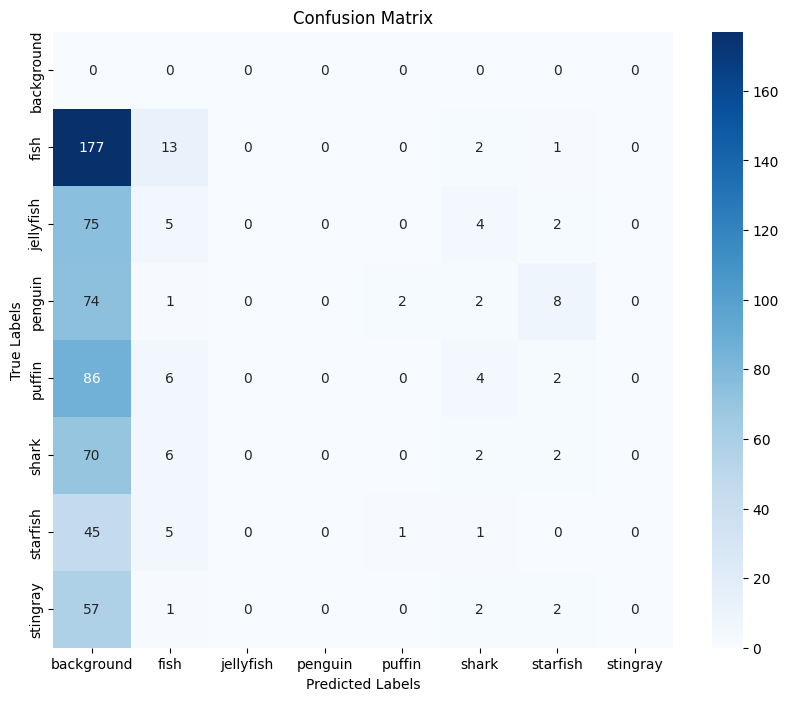

In [46]:
class_names = ['background', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

evaluator.plot_confusion_matrix(conf_matrix, class_names)  # Modify class names if needed

In [47]:
import torch
import matplotlib.pyplot as plt
from torchmetrics.detection import MeanAveragePrecision
from torchmetrics import ConfusionMatrix
import numpy as np
import seaborn as sns
import time
import cv2
import random


class Visualize:
    def __init__(self, y_pred, y_true, images, num_images, class_names):
        self.y_pred = y_pred
        self.y_true = y_true
        self.images = images
        self.num_images = num_images
        self.class_names = class_names

    def visualize_predictions(self, image, pred, gt, class_names):
        """
        Visualizes predicted and ground truth bounding boxes on an image.

        Args:
            image (torch.Tensor): The input image (shape: C, H, W).
            pred (dict): The model's predictions (contains 'boxes' and 'labels').
            gt (dict): The ground truth labels (contains 'boxes' and 'labels').
            class_names (list): List of class names for labeling the boxes.

        Returns:
            None (Displays the image with bounding boxes).
        """

        # Convert image from Tensor to NumPy and ensure it’s `uint8`
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
        image = (image * 255).astype(np.uint8).copy()  # Convert from [0,1] to [0,255] and ensure contiguous memory

        # Ensure image has 3 color channels (RGB)
        if image.shape[-1] == 1:  # If grayscale, convert to RGB
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Define colors for bounding boxes
        COLORS = {i: [random.randint(0, 255) for _ in range(3)] for i in range(len(class_names))}

        def draw_boxes(boxes, labels, color, label_prefix):
            for box, label in zip(boxes, labels):
                # Ensure box is converted from tensor to list, then to integers
                x1, y1, x2, y2 = map(int, box.tolist())
                # Ensure coordinates do not go negative
                x1, y1, x2, y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2)

                class_name = class_names[label] if label < len(class_names) else f"Class {label}"

                # Draw rectangle
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                # Draw label
                cv2.putText(image, f"{label_prefix} {class_name}", (x1, max(0, y1 - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw Ground Truth (Green)
        draw_boxes(gt["boxes"], gt["labels"], (0, 255, 0), "GT")

        # Draw Predictions (Red)
        draw_boxes(pred["boxes"], pred["labels"], (255, 0, 0), "Pred")

        # Show the image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.axis("off")
        plt.title("Predictions vs Ground Truth")
        plt.show()

    def visualize_batch(self, y_pred, y_true, images, num_images=5, class_names=None):
        """
        Visualizes model predictions vs. ground truth on a batch of images.

        Args:
            y_pred (list): List of predicted bounding boxes and labels.
            y_true (list): List of ground truth bounding boxes and labels.
            images (list): List of images **from collect_predictions()**.
            num_images (int): Number of images to visualize.
            class_names (list): List of class names for labeling the boxes.

        Returns:
            None (Displays images with bounding boxes).
        """
        # Ensure all images are on CPU
        images = [img.cpu() for img in images]

        # Plot num_images images
        for i in range(min(num_images, len(images))):
            self.visualize_predictions(images[i], y_pred[i], y_true[i], class_names)

In [48]:
# Initialize the Evaluate class
visualizer = Visualize(y_pred, y_true, images, num_images=5, class_names=class_names)


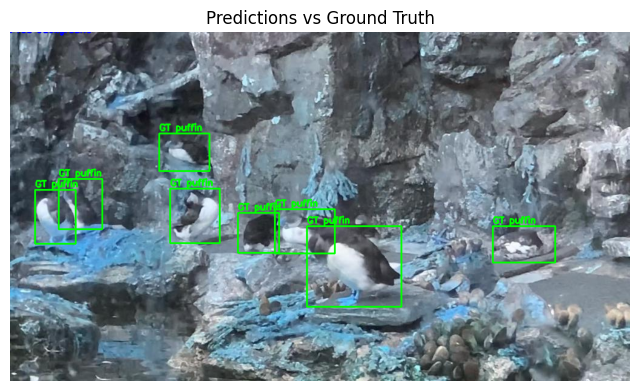

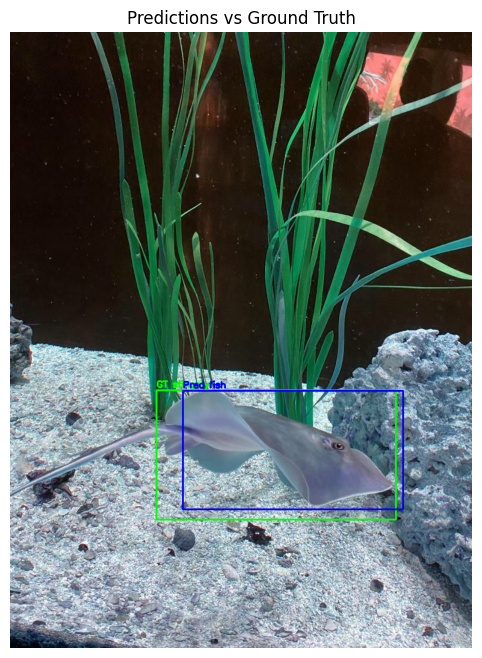

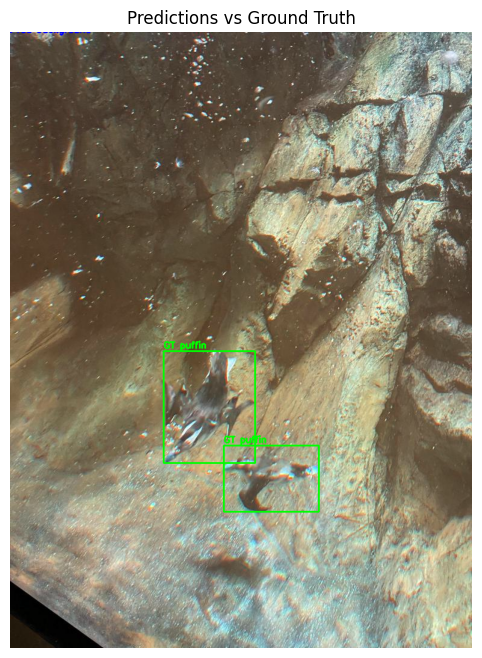

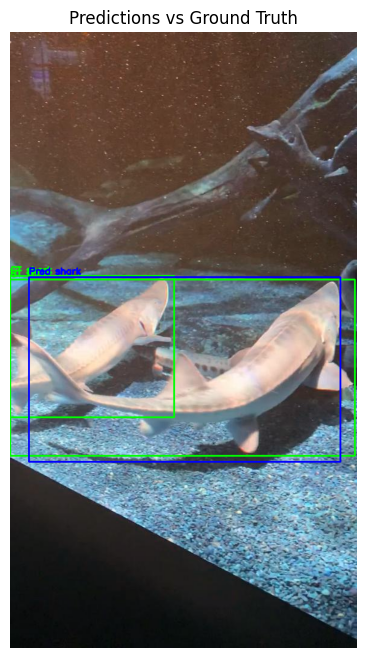

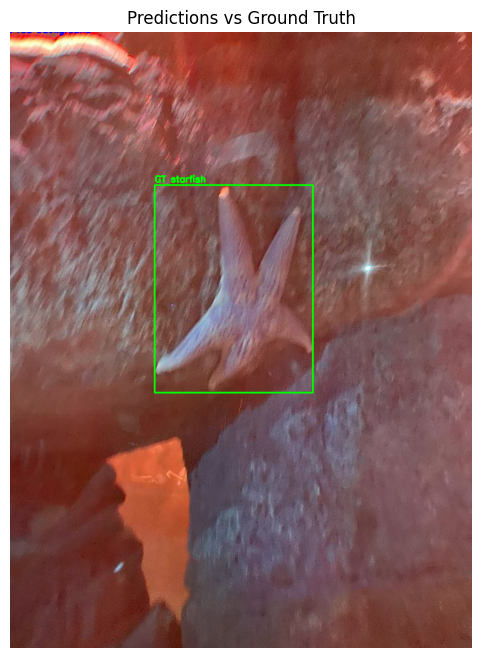

In [49]:
visualizer.visualize_batch(y_pred, y_true, images, num_images=5, class_names=class_names)


# Save Checkpoints

In [ ]:
torch.save(model.state_dict(), "fasterrcnn_resnet50_aquarium.pth")


In [ ]:
checkpoint = torch.load("./checkpoints/fasterrcnn_resnet50_aquarium.pth", weights_only=True)
model.load_state_dict(checkpoint)

In [ ]:
print(model)